In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

**Aim of the project:**

Based on the information that we have, how can we predict the sale price of a house? 

There are many differect characteristics used in the problem (79 columns). So it'll involved a little bit of feature engineering. 

My first point of entry will be to look into regular exploratory data analysis and then see what happens from there.



In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# Basic cleaning

In [4]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
na_df = pd.DataFrame(train_df.isna().sum())
# Some features have too many items missing so any imputation would be a significant extrapolation. I'm going to remove features that are like that. Because there are so many columns, I'll for something like 20% 

In [7]:
# Removing columsn that have over 20% of their items missing. 
# Will also want to print the columns that were dropped 

training_copy = train_df.copy()

# Data frame that contains columns that have at least 80% of their values. There is no reason behind this number. 
training_copy_2 = training_copy[[col for col in training_copy if training_copy[col].count() / len(training_copy) >= 0.2]]

print("Columns dropped: ")
for c in training_copy.columns:
    if c not in training_copy_2.columns:
        print(c)

main_train = training_copy_2


Columns dropped: 
Alley
PoolQC
Fence
MiscFeature


In [8]:
# now we should probably separate columns that have categorical missing information and numerical information. 

numerical_cols = [col for col in main_train.columns if main_train[col].dtype in ["int64", "float64"]]
categorical_cols = [col for col in main_train.columns if main_train[col].nunique() > 15 and main_train[col].dtype == "object"]

In [9]:
main_train_cleaned = numerical_cols + categorical_cols
main_train_cleaned = main_train[main_train_cleaned]
main_train_cleaned.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Neighborhood,Exterior2nd
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,0,2,2008,208500,CollgCr,VinylSd
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,5,2007,181500,Veenker,MetalSd
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,0,9,2008,223500,CollgCr,VinylSd
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,272,0,0,0,0,2,2006,140000,Crawfor,Wd Shng
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,0,12,2008,250000,NoRidge,VinylSd


## Exploratory data analysis

Now I need to complete some exploratory data analysis to make sure that I understand what I'm looking at. It'd also help to sure that the data sets that I am looking at are meaningful. 

Also need to include some data cleaning so that the graphs we will have are actually useful.

In [10]:
main_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

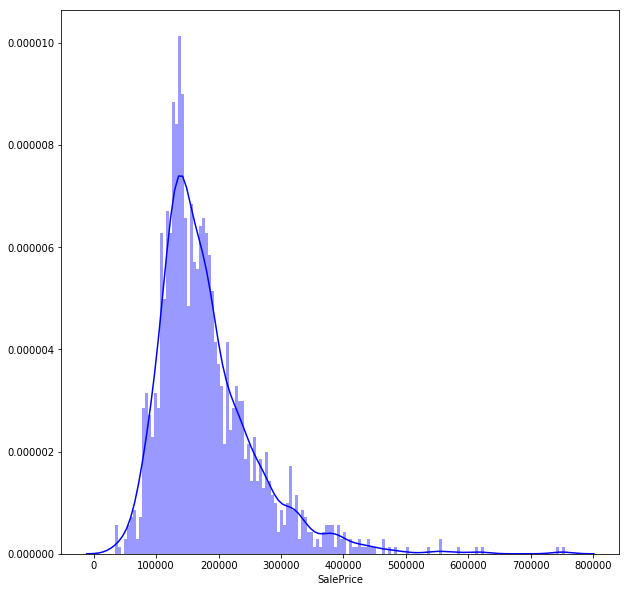

In [11]:
# Time to get some graphs going... where to start.

plt.figure(figsize=(10,10))
sns.distplot(main_train["SalePrice"], color="b", bins=150)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000243598738D0>,
      dtype=object)

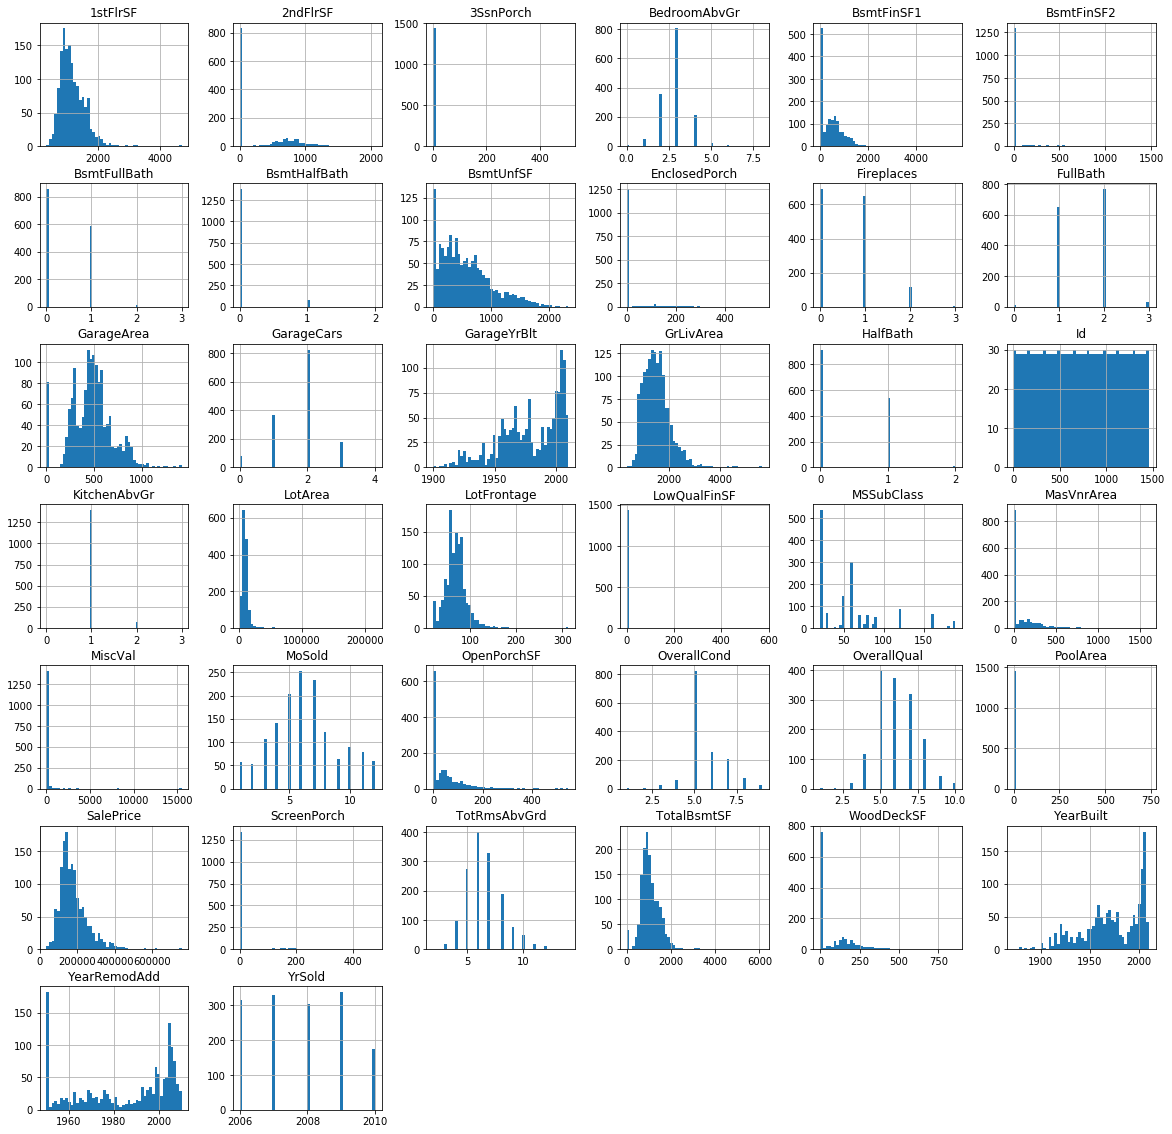

In [15]:
df_numerical = main_train[numerical_cols]
df_numerical.hist(figsize=(20,20), bins=50)

In [16]:
# Which features correlate the most with the sale price? Maybe we'll use that later to see if we can make a model with just those features... 
df_numerical_correlation = df_numerical.corr()["SalePrice"].drop("SalePrice")

best_correlation = df_numerical_correlation[abs(df_numerical_correlation) > 0.5].sort_values(ascending=False)

print(f"Here are the top {len(best_correlation)} features that best correlate with sale price: \n \n{best_correlation}")

Here are the top 10 features that best correlate with sale price: 
 
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


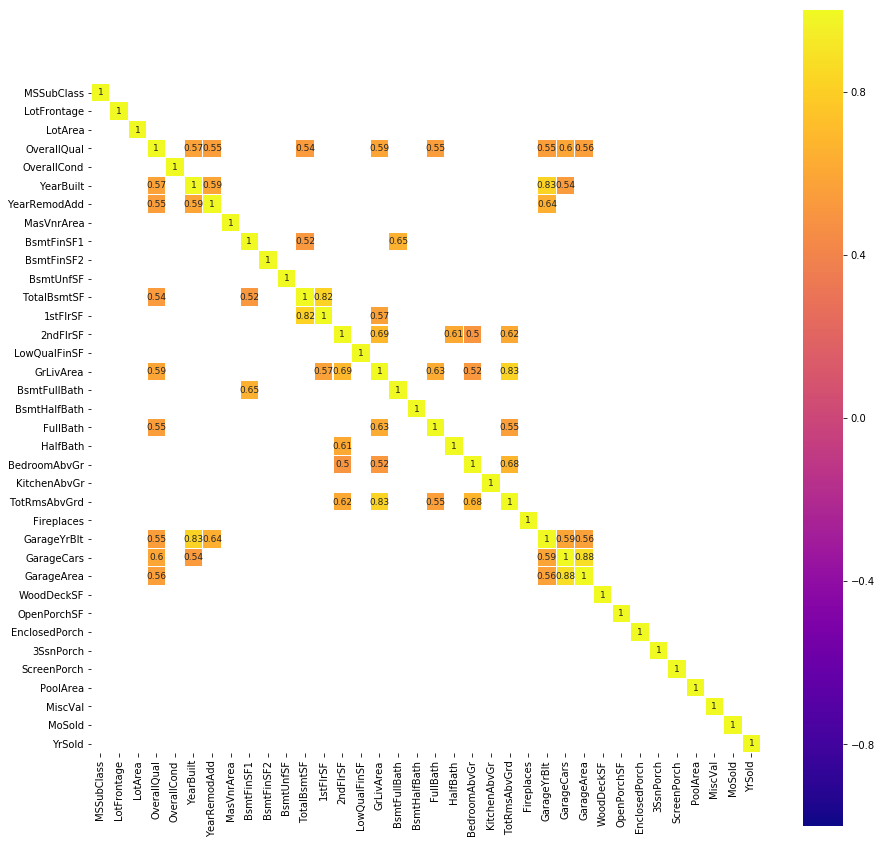

In [17]:
# Now let's have a look at some other visualisations we can do before doing something a bit more interesting. 

# Which ones might he correlated to each other? 

other_correlations = df_numerical.drop(["SalePrice", "Id"], axis=1).corr()
plt.figure(figsize=(15,15))

sns.heatmap(other_correlations[((other_correlations>=0.5) | (other_correlations<=-0.5))], cmap="plasma", annot=True, annot_kws={"size": 9}, square=True, vmax=1.0, vmin=-1.0, linewidths=0.1)


## Creation of a pipeline 

Need to create a pipeline and then find a bunch of different models that I could consider using. 

In [41]:
# The data set minus the target predictor, and the predictor.
# This creates the most basic foundation for us to work on. I've already cleaned some of the data above (numerical and objects with cardinality below 15.)
X = main_train_cleaned
y = main_train_cleaned.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.8,test_size=0.2)


In [42]:
X.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Neighborhood,Exterior2nd
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,0,2,2008,208500,CollgCr,VinylSd
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,5,2007,181500,Veenker,MetalSd
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,0,9,2008,223500,CollgCr,VinylSd
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,272,0,0,0,0,2,2006,140000,Crawfor,Wd Shng
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,0,12,2008,250000,NoRidge,VinylSd


In [43]:
# Now to start processing the data so the train_test_split is actually meaningful (because we still have a lot of missing data within the columns!)

# Preprocessing numerical information 
numerical_transformer = SimpleImputer(strategy=("mean"))

# Preprocessing categorical information 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Putting them all together into one pipeline 

preprocessor = ColumnTransformer(transformers=[
    ("cat", categorical_transformer, categorical_cols),
    ("num", numerical_transformer, numerical_cols)
    ])

In [44]:
# Now we can bundle them into one pipeline 

# need to import the model I'd like to try and the MAE test
model = XGBRegressor()
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("model", model)])
                                

In [45]:
my_pipeline.fit(X_train, y_train)

predictions = my_pipeline.predict(X_valid)
print("MAE: " + str(mean_absolute_error(predictions, y_valid)))

MAE: 1358.5723994006848


In [46]:
# Now we can test a  few different models to see how accurate they are. 

models = [("basic XGBoost", XGBRegressor()),
        ("XGBoost w/ n_500", XGBRegressor(n_estimators=500)),
        ("XGBoost w/ n_300", XGBRegressor(n_estimators=300)),
        ("Random Trees", RandomForestRegressor())]

for name, model in models:
    my_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                            ("model", model)])
    
    my_pipeline.fit(X_train, y_train)

    predict = my_pipeline.predict(X_valid)

    print(f"MAE for {name}: " + str(mean_absolute_error(predict, y_valid)))

# These seem a bit too accurate... I'm not sure what I've done wrong here.

MAE for basic XGBoost: 1358.5723994006848
MAE for XGBoost w/ n_500: 1351.692677119007
MAE for XGBoost w/ n_300: 1351.6345114511987
MAE for Random Trees: 487.766095890411
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [47]:
# Final prediction with the test data 

test_data_model = XGBRegressor(n_estimators=300)

my_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("model", model)])

my_pipeline.fit(X_train, y_train)

main_cols = numerical_cols + categorical_cols

X_test = test_df.copy()

test_prediction = my_pipeline.predict(X_test)

output = pd.DataFrame({"Id": X_test.Id,
                        "SalePrice" : test_prediction})

output.to_csv("Housing prices prediction attempt 4.csv", index=False)

# output.head()


C:\Users\OJ595\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [48]:
# Testing with cross validation because we have a small ish data set
models = [("basic XGBoost", XGBRegressor()),
        ("XGBoost w/ n_500", XGBRegressor(n_estimators=500)),
        ("XGBoost w/ n_300", XGBRegressor(n_estimators=300)),
        ("Random Trees", RandomForestRegressor()),
        ("Random 60", RandomForestRegressor(n_estimators=60)),
        ("Random 70", RandomForestRegressor(n_estimators=70))]
   
for name, model in models:
    my_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                            ("model", model)])

# Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

    print(f"MAE for {name}: " + str(scores.mean()))



MAE for basic XGBoost: 1353.1004842679795
MAE for XGBoost w/ n_500: 1347.5837194991439
MAE for XGBoost w/ n_300: 1347.6074860873287
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

In [49]:
# Preprocessing numerical information 
numerical_transformer = SimpleImputer(strategy=("most_frequent"))

# Preprocessing categorical information 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Putting them all together into one pipeline 

preprocessor = ColumnTransformer(transformers=[
    ("cat", categorical_transformer, categorical_cols),
    ("num", numerical_transformer, numerical_cols)
    ])

models = [("basic XGBoost", XGBRegressor()),
        ("XGBoost w/ n_500", XGBRegressor(n_estimators=500)),
        ("XGBoost w/ n_300", XGBRegressor(n_estimators=300)),
        ("Random Trees", RandomForestRegressor()),
        ("Random 60", RandomForestRegressor(n_estimators=60)),
        ("Random 70", RandomForestRegressor(n_estimators=70))]
   
for name, model in models:
    my_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                            ("model", model)])

# Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

    print(f"MAE for {name}: " + str(scores.mean()))

MAE for basic XGBoost: 1355.120566673801
MAE for XGBoost w/ n_500: 1347.846385380993
MAE for XGBoost w/ n_300: 1347.8497565282535
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\OJ595\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
 